In [1]:
import os
import cv2
import pickle

import numpy as np
import pandas as pd
import nibabel as nib

from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

def compare(images, titles=None, fig_title=None, rows=1, cols=None, figsize=(10, 5), cmap="gray", save_path=None):
    """
    Displays a list of images for comparison in a grid format and optionally saves the figure.
    
    Parameters:
    - images: A list of images (as NumPy arrays) to display.
    - titles: Optional list of titles for the images (default: None).
    - rows: Number of rows in the grid (default: 1).
    - cols: Number of columns in the grid (if not provided, calculated automatically).
    - figsize: Size of the entire figure (default: (10, 5)).
    - cmap: Colormap for displaying images (default: "gray").
    - save_path: File path to save the figure (default: None). If None, the figure is not saved.
    
    Returns:
    - None: Displays the images in a grid and saves the figure if a save_path is provided.
    """
    # Determine the number of columns if not provided
    if cols is None:
        cols = len(images) // rows if len(images) % rows == 0 else (len(images) // rows) + 1

    # Create the figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten the axes array if there are multiple rows and columns
    if rows * cols > 1:
        axes = axes.ravel()

    # Loop through images and display them
    for i in range(len(images)):
        axes[i].imshow(images[i], cmap=cmap)
        axes[i].axis('off')  # Hide the axis
        
        # Set the title if provided and if there are enough titles
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])

    # Hide any remaining axes if there are more subplots than images
    for j in range(len(images), rows * cols):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    
    # Set the overall figure title if provided
    if fig_title is not None:
        fig.suptitle(fig_title, fontsize=16)
    
    # Save the figure if save_path is provided
    if save_path:
        print(f"Saving figure to {save_path}")
        plt.savefig(save_path)
    
    # Show the figure
    plt.show()

In [2]:
OUTPUT_PATH = r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\output2"
TEMPLATE_OUTPUT_PATH = r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\output-template"
TEST_SET_PATH = r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\test-set"
ATLAS_PATH = r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\result-atlas2\atlas_intensity.nii.gz"
TEMPLATE_ATLAS_PATH = r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\template-atlas"
CASES = os.listdir(OUTPUT_PATH)

In [3]:
def imread_nii(path):
    atlas_img = nib.load(path)
    return atlas_img.get_fdata()


def affine_nii(path):
    atlas_img = nib.load(path)
    return atlas_img.affine


def files_for_case(case_id, template_atlas=False):
    case_id = str(case_id)
    path = TEMPLATE_OUTPUT_PATH if template_atlas else OUTPUT_PATH
    files = [i if ".gz" in i else None for i in os.listdir(fr"{path}\{case_id}" )]
    files = [i for i in files if i is not None]

    files = list(map(
        lambda x: f"{os.path.join(path,case_id,x)}",
        files
    ))
    # print(files)
    return files

def mask_for_case(case_id):
    mask_path = os.path.join(TEST_SET_PATH, "testing-mask", f"{str(case_id)}_1C.nii.gz")
    return imread_nii(mask_path)

def labels_for_case(case_id):
    labels_path = os.path.join(TEST_SET_PATH, "testing-labels", f"{str(case_id)}_3C.nii.gz")
    return imread_nii(labels_path)    

def image_for_case(case_id):
    image_path = os.path.join(TEST_SET_PATH, "testing-images", f"{str(case_id)}.nii.gz")
    return imread_nii(image_path)    

def results_for_case(case_id, template_atlas=False):
    files = files_for_case(case_id, template_atlas=template_atlas)    
    results = {
        "registered_image": imread_nii(files[1]),
        "probmap0": imread_nii(files[2]),
        "probmap1": imread_nii(files[3]),
        "probmap2": imread_nii(files[4]),
        "probmap3": imread_nii(files[5])
    }
    results["probmaps"] = np.stack([results["probmap0"], results["probmap1"], results["probmap2"], results["probmap3"]], axis=-1)
    
    results["probmaps"][results["probmaps"] < 0] = 0
    
    results["labels"] = np.argmax(results["probmaps"], axis=3)  
    
    return results

# Load the tissue histograms and bins
def load_histograms(filepath):
    with open(filepath, 'rb') as f:
        histograms = pickle.load(f)
    return histograms["CSF"], histograms["GM"], histograms["WM"], histograms["bins"]

In [4]:
def dice_score(pred, gt, smooth=1e-5):
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()

    intersection = np.sum(pred_flat * gt_flat)
    pred_sum = np.sum(pred_flat)
    gt_sum = np.sum(gt_flat)

    dice = (2. * intersection + smooth) / (pred_sum + gt_sum + smooth)
    return dice

def dice_score_per_label(ground_truth, prediction, labels):
    dice_scores = {}
    for label in labels:
        # Create binary masks
        gt_mask = (ground_truth == label).astype(int)
        pred_mask = (prediction == label).astype(int)
        
        # Calculate F1 score as Dice score
        dice = dice_score(gt_mask.ravel(), pred_mask.ravel())
        dice_scores[label] = dice
    
    return dice_scores

In [33]:

def reorder_labels_by_intensity(intensity_image, mask_image, num_labels):
    mean_intensities = []

    # Calculate mean intensity for each label
    for label in range(1, num_labels + 1):
        label_mask = mask_image == label
        mean_intensity = np.mean(intensity_image[label_mask]) if np.any(label_mask) else 0
        mean_intensities.append((label, mean_intensity))

    # Sort by intensity
    sorted_labels = sorted(mean_intensities, key=lambda x: x[1])

    # Re-map labels
    label_mapping = {old_label: new_label for new_label, (old_label, _) in enumerate(sorted_labels, start=1)}

    # Apply new label mapping
    reordered_mask = np.zeros(shape=mask_image.shape)
    for old_label, new_label in label_mapping.items():
        reordered_mask[mask_image == old_label] = new_label

    return reordered_mask

# Atlas

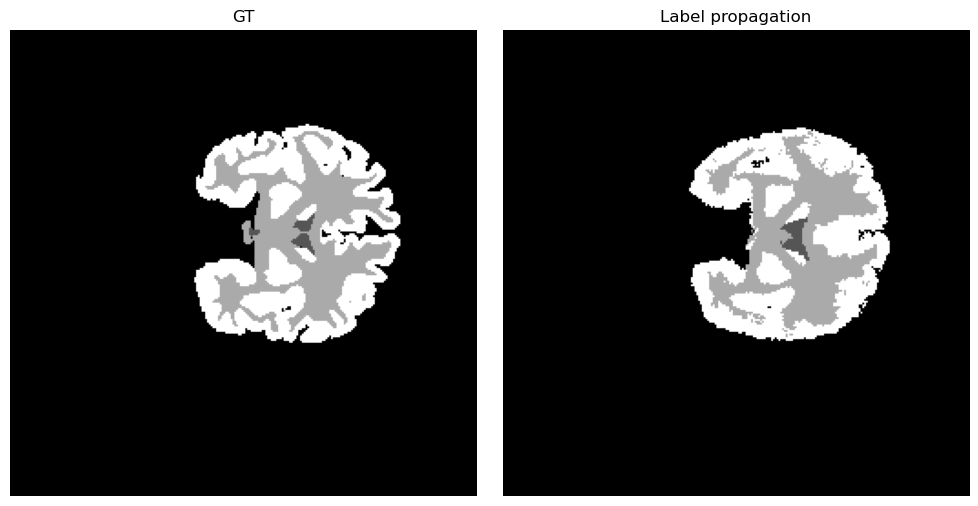

In [5]:
# plt.imshow(results_for_case(1003)["labels"][:,160,:])
compare([labels_for_case(1003)[:,160,:],results_for_case(1003)["labels"][:,160,:],],
        ["GT", "Label propagation"])

In [6]:
# template_atlas = imread_nii(os.path.join(TEMPLATE_ATLAS_PATH, "atlas.nii.gz"))
# template_affine = affine_nii(os.path.join(TEMPLATE_ATLAS_PATH, "atlas.nii.gz"))
# 
# for i in range(4):
#     print(f"Label {i}")
#     nifti = nib.Nifti1Image(template_atlas[:,:,:,i], template_affine)
#     path = os.path.join(
#         TEMPLATE_ATLAS_PATH,
#         f"atlas_probability_label_{i}.nii.gz"
#     )
#     nib.save(nifti, path)
#     
# template_atlas.shape

## Trained

### Label propagation segmentation


case 1003, idx 0


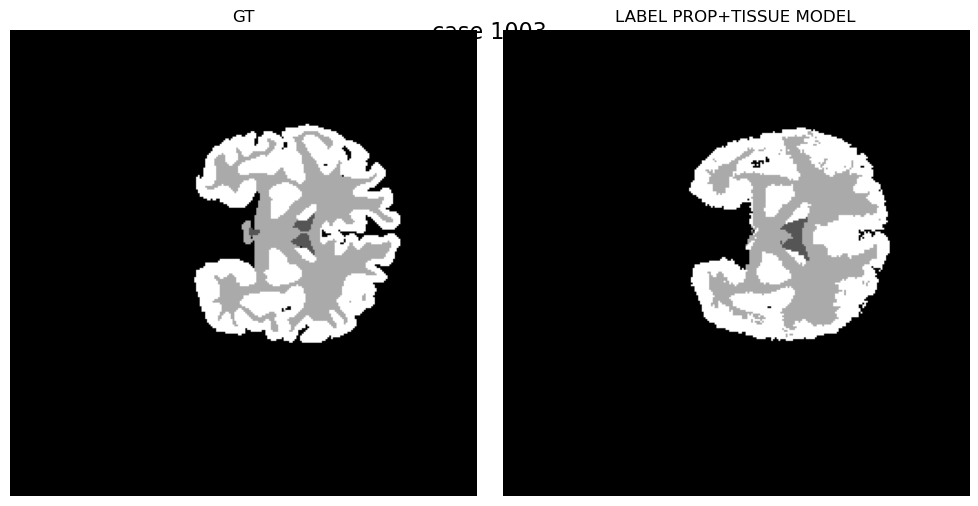

Dice for case 1003
{1: 0.574823616981608, 2: 0.7716197141205047, 3: 0.7460626942557314}
case 1004, idx 1
Dice for case 1004
{1: 0.6953874258805335, 2: 0.7622283250644715, 3: 0.7577554318083001}
case 1005, idx 2
Dice for case 1005
{1: 0.7863581517685465, 2: 0.7311251987153355, 3: 0.7423592442869704}
case 1018, idx 3
Dice for case 1018
{1: 0.6862527292732782, 2: 0.7690187234996928, 3: 0.7759835280403139}
case 1019, idx 4
Dice for case 1019
{1: 0.6120849661723629, 2: 0.7556499306920669, 3: 0.7634067423597026}
case 1023, idx 5


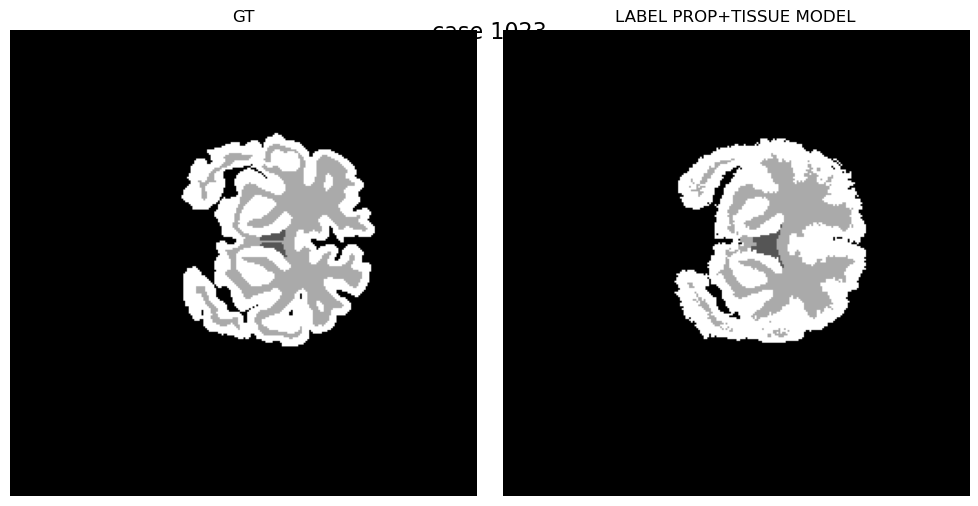

Dice for case 1023
{1: 0.5792671529354706, 2: 0.7628941518895801, 3: 0.7573733581554296}
case 1024, idx 6
Dice for case 1024
{1: 0.6800463888666818, 2: 0.7620798973120483, 3: 0.7710986594346435}
case 1025, idx 7
Dice for case 1025
{1: 0.7746115373178175, 2: 0.7322765198090574, 3: 0.7570098741686512}
case 1038, idx 8
Dice for case 1038
{1: 0.7146068995592613, 2: 0.7686067463225296, 3: 0.7758842876668308}
case 1039, idx 9
Dice for case 1039
{1: 0.6415490845384023, 2: 0.7559578533780619, 3: 0.7557202137594154}
case 1101, idx 10


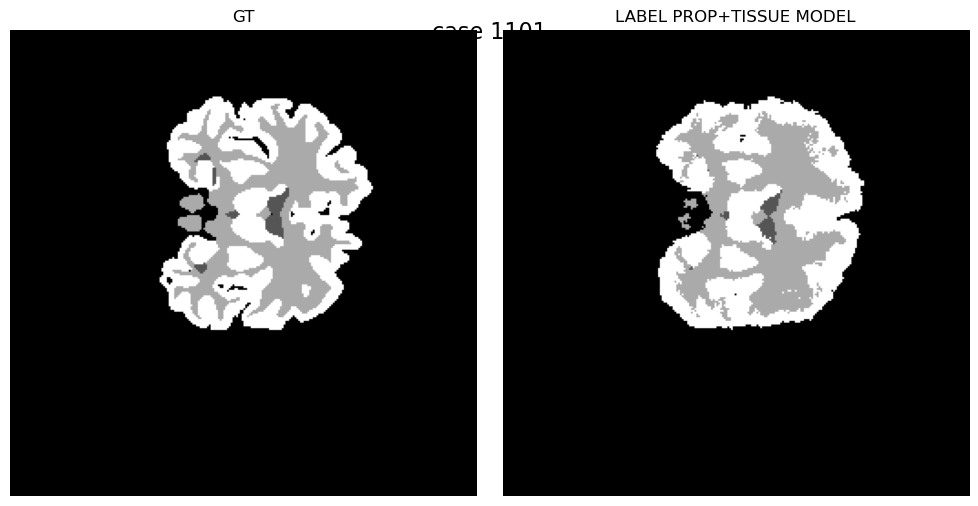

Dice for case 1101
{1: 0.739687338450279, 2: 0.7630089979849685, 3: 0.7663025641870185}
case 1104, idx 11
Dice for case 1104
{1: 0.7144428463450255, 2: 0.7673236997705248, 3: 0.7798179003832986}
case 1107, idx 12
Dice for case 1107
{1: 0.6838686780181478, 2: 0.7867897447120548, 3: 0.7474291928565351}
case 1110, idx 13
Dice for case 1110
{1: 0.7107537269376409, 2: 0.7794146801382963, 3: 0.7721052092443617}
case 1113, idx 14
Dice for case 1113
{1: 0.7115838644077114, 2: 0.7757120438372744, 3: 0.7444581999041389}
case 1116, idx 15


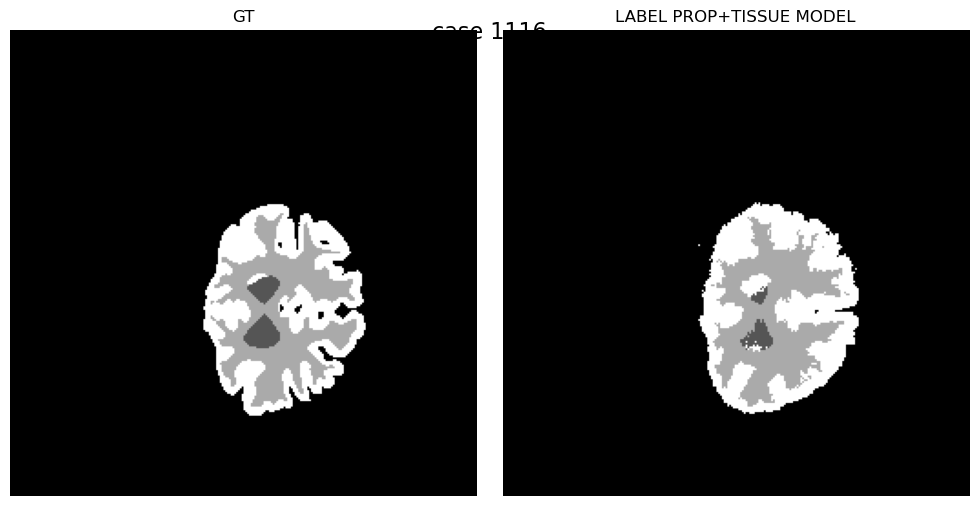

Dice for case 1116
{1: 0.7451242179448252, 2: 0.7402049335743812, 3: 0.7465797939198415}
case 1119, idx 16
Dice for case 1119
{1: 0.7899834632854965, 2: 0.7479262077162921, 3: 0.6960579956119034}
case 1122, idx 17
Dice for case 1122
{1: 0.7601032055753284, 2: 0.7698985094200171, 3: 0.7541640991042103}
case 1125, idx 18
Dice for case 1125
{1: 0.8055699442544282, 2: 0.7620149874967671, 3: 0.7427556088881789}
case 1128, idx 19
Dice for case 1128
{1: 0.7336452354967692, 2: 0.7603681738014361, 3: 0.7325123660793449}


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.574824,0.695387,0.786358,0.686253,0.612085,0.579267,0.680046,0.774612,0.714607,0.641549,0.739687,0.714443,0.683869,0.710754,0.711584,0.745124,0.789983,0.760103,0.805570,0.733645
2,0.771620,0.762228,0.731125,0.769019,0.755650,0.762894,0.762080,0.732277,0.768607,0.755958,0.763009,0.767324,0.786790,0.779415,0.775712,0.740205,0.747926,0.769899,0.762015,0.760368
3,0.746063,0.757755,0.742359,0.775984,0.763407,0.757373,0.771099,0.757010,0.775884,0.755720,0.766303,0.779818,0.747429,0.772105,0.744458,0.746580,0.696058,0.754164,0.742756,0.732512


In [7]:
gts = []
masks = []
registered_labels = []
dice_scores = {}
#segmentation_method(atlas_path)

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        results = results_for_case(case_id)

        registered_labels.append(results["labels"])
        
        if i % 5 == 0:
            compare([gts[i][:,160,:], registered_labels[i][:,160,:]],["GT", "LABEL PROP+TISSUE MODEL"], fig_title=f"case {case_id}")
            
        
        dice =  dice_score_per_label(gts[i].ravel(), registered_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)
trained_df_label_propagation = pd.DataFrame(data=dice_scores)

trained_df_label_propagation

In [8]:
trained_df_label_propagation_dices = pd.DataFrame(trained_df_label_propagation.T.mean(), columns=["label_prop_segment"])
trained_df_label_propagation_dices

,label_prop_segment
1,0.706988
2,0.761206
3,0.754242


### Tissue-model segmentation

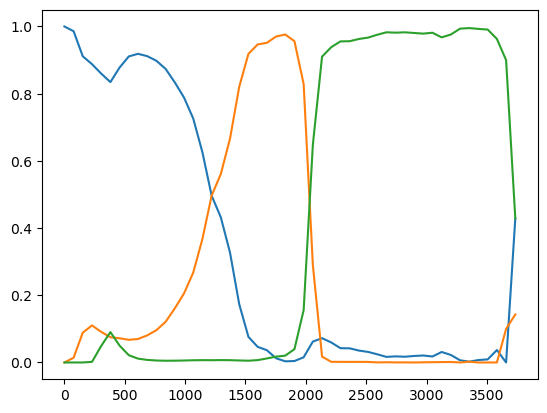

In [9]:
# Normalize the histograms to the range [0, 1]
def normalize_histograms(hists):
    hists = np.array(hists)
    for i, tissue_type in enumerate(hists):
        h = hists[i]
        hists[i] = h / np.max(h)  # Scale histogram to [0, 1]
    return hists

histograms = load_histograms(r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\tissue-model\tissue_histograms.pkl")
bins = histograms[3]

csf_hist = histograms[0]
gm_hist = histograms[1]
wm_hist = histograms[2]

plt.plot(bins, csf_hist)
plt.plot(bins, gm_hist, )
plt.plot(bins, wm_hist, )
plt.show()

In [58]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Pre-compute smoothed histograms outside the loop if smoothing is needed
def smooth_histogram(histogram, sigma=0.5):
    return gaussian_filter(histogram, sigma=sigma)

# Optimized segmentation function
def optimized_tissue_model_segmentation(img, binary_mask, bins, csf_histogram, gm_histogram, wm_histogram):
    segmented_image = np.zeros_like(img, dtype=np.uint8)
    csf_weight, gm_weight, wm_weight = 50.0, 1.0, 1.0  # Set weights

    # Pre-smooth histograms once if needed
    # csf_histogram = smooth_histogram(csf_histogram) * csf_weight
    # gm_histogram = smooth_histogram(gm_histogram) * gm_weight
    # wm_histogram = smooth_histogram(wm_histogram) * wm_weight

    # Digitize the image intensities to get bin indices
    bin_indices = np.digitize(img, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(csf_histogram) - 1)

    # Apply the tissue model segmentation within the binary mask
    for idx in np.argwhere(binary_mask):
        bin_index = bin_indices[tuple(idx)]
        
        # Retrieve smoothed probabilities
        csf_prob, gm_prob, wm_prob = (
            csf_histogram[bin_index],
            gm_histogram[bin_index],
            wm_histogram[bin_index]
        )

        # Assign label based on maximum probability
        max_prob = max(csf_prob, gm_prob, wm_prob)
        if max_prob == csf_prob:
            segmented_image[tuple(idx)] = 3  # CSF label
        elif max_prob == gm_prob:
            segmented_image[tuple(idx)] = 2  # GM label
        else:
            segmented_image[tuple(idx)] = 1  # WM label

    return segmented_image


In [59]:
gts = []
masks = []
registered_labels = []
dice_scores = {}

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        results = results_for_case(case_id)

        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 5000, cv2.NORM_MINMAX)

        registered_labels.append(
            optimized_tissue_model_segmentation(
                image, masks[i], bins, csf_hist, gm_hist, wm_hist))
        
        dice =  dice_score_per_label(gts[i].ravel(), registered_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(dice)
        print(f"Dice for case {case_id}")
    except Exception as e:
        print(e)


trained_df_tissue_model = pd.DataFrame(data=dice_scores)
trained_df_tissue_model

case 1003, idx 0
{1: 1.0622477150390402e-09, 2: 0.8878160269921294, 3: 0.9130518215754881}
Dice for case 1003
case 1004, idx 1
{1: 6.309148261003692e-10, 2: 0.9254112087605004, 3: 0.9438431036929216}
Dice for case 1004
case 1005, idx 2
{1: 1.5826290631496488e-10, 2: 0.8742629831696784, 3: 0.8796386419300116}
Dice for case 1005
case 1018, idx 3
{1: 7.940919552179053e-10, 2: 0.8729366156481957, 3: 0.8944268656035105}
Dice for case 1018
case 1019, idx 4
{1: 1.1761938353608636e-09, 2: 0.9032244272483879, 3: 0.9347627938841344}
Dice for case 1019
case 1023, idx 5
{1: 1.0889687454111198e-09, 2: 0.8802253173387324, 3: 0.9040164544809391}
Dice for case 1023
case 1024, idx 6
{1: 6.910372464300759e-10, 2: 0.8652982870419124, 3: 0.8961034839230394}
Dice for case 1024
case 1025, idx 7
{1: 1.5771129368086943e-10, 2: 0.9097925368534574, 3: 0.9146476280542764}
Dice for case 1025
case 1038, idx 8
{1: 6.841817181963727e-10, 2: 0.8755328465352757, 3: 0.8952767502405741}
Dice for case 1038
case 1039, idx

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,1.062248e-09,6.309148e-10,1.582629e-10,7.940920e-10,1.176194e-09,1.088969e-09,6.910372e-10,1.577113e-10,6.841817e-10,1.037990e-09,3.631478e-10,5.178932e-10,1.277972e-10,4.563501e-10,4.510600e-10,2.309682e-10,1.469637e-10,8.566118e-11,1.377942e-10,2.737551e-10
2,8.878160e-01,9.254112e-01,8.742630e-01,8.729366e-01,9.032244e-01,8.802253e-01,8.652983e-01,9.097925e-01,8.755328e-01,8.786895e-01,8.660972e-01,7.650466e-01,7.111482e-01,9.231553e-01,9.036218e-01,9.137758e-01,8.047773e-01,6.320440e-01,8.059985e-01,7.575993e-01
3,9.130518e-01,9.438431e-01,8.796386e-01,8.944269e-01,9.347628e-01,9.040165e-01,8.961035e-01,9.146476e-01,8.952768e-01,9.081743e-01,8.861567e-01,7.854839e-01,8.035481e-01,9.442973e-01,9.150071e-01,9.220594e-01,8.105413e-01,6.846758e-01,7.851690e-01,7.760516e-01


In [12]:
trained_df_tissue_model_dices = pd.DataFrame(trained_df_tissue_model.T.mean(), columns=["tissue_mod_segment"])

trained_df_tissue_model_dices = trained_df_tissue_model_dices.apply(lambda row: np.round(row, 6))
trained_df_tissue_model_dices

,tissue_mod_segment
1,0.000000
2,0.847823
3,0.869847


### Tissue-model & Label-propagation segmentation

In [13]:
# Function to get intensity-based probability from tissue histograms
def get_intensity_probability(intensity_values, histogram, bins):
    bin_indices = np.digitize(intensity_values, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(histogram) - 1)  # Ensure index is within range
    return histogram[bin_indices]

# Vectorized segmentation combining intensity and position information
def segment_using_intensity_and_position(image, csf_map, gm_map, wm_map, intensity_bins, csf_histogram, gm_histogram, wm_histogram, bg_map=None):
    # Initialize segmented image
    segmented_image = np.zeros_like(image, dtype=int)

    # Get intensity-based probabilities for CSF, GM, and WM
    csf_intensity_prob = get_intensity_probability(image, csf_histogram, intensity_bins)
    gm_intensity_prob = get_intensity_probability(image, gm_histogram, intensity_bins)
    wm_intensity_prob = get_intensity_probability(image, wm_histogram, intensity_bins)

    # Compute combined probabilities by multiplying intensity and position maps
    csf_combined_prob = csf_intensity_prob * csf_map
    gm_combined_prob = gm_intensity_prob * gm_map
    wm_combined_prob = wm_intensity_prob * wm_map

    print((csf_combined_prob.min(), csf_combined_prob.max()))
    print((gm_combined_prob.min(), gm_combined_prob.max()))
    print((wm_combined_prob.min(), wm_combined_prob.max()))

    # Stack combined probabilities along a new dimension for argmax
    combined_probs = np.stack([csf_combined_prob, gm_combined_prob, wm_combined_prob], axis=-1)

    # Determine the label with the highest combined probability, including background if provided
    if bg_map is not None:
        combined_probs_with_bg = np.concatenate((bg_map[..., np.newaxis], combined_probs), axis=-1)
        segmented_image = np.argmax(combined_probs_with_bg, axis=-1)  # 0=background, 1=WM, 2=GM, 3=CSF
    else:
        segmented_image = np.argmax(combined_probs, axis=-1) + 1  # Labels: 1=WM, 2=GM, 3=CSF

    return segmented_image

case 1003, idx 0
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.8714313740710473)


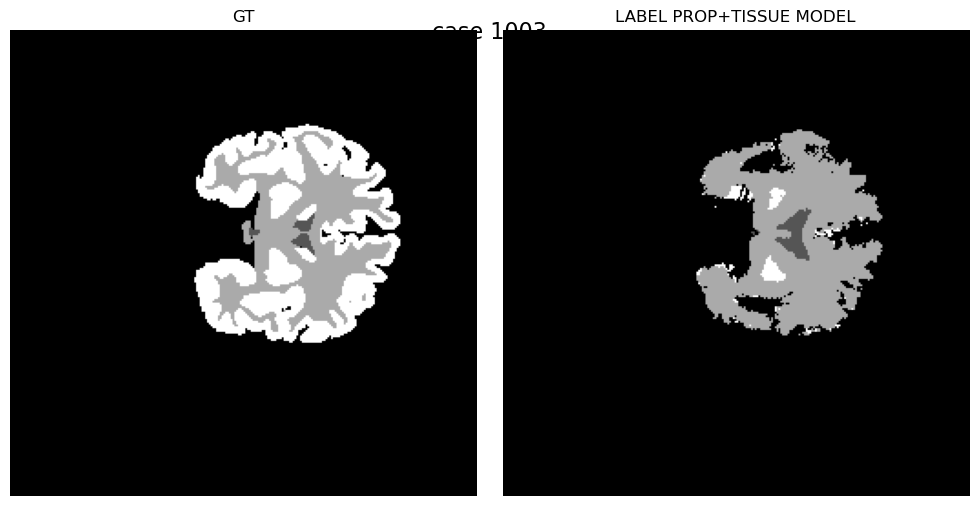

{1: 0.555866099359758, 2: 0.7354480525134743, 3: 0.1148263216356004}
Dice for case 1003
case 1004, idx 1
(0.0, 0.9859088774072334)
(0.0, 0.9762024956716513)
(0.0, 0.8714313740710473)
{1: 0.5893277630859612, 2: 0.7275339790023835, 3: 0.1370644723481093}
Dice for case 1004
case 1005, idx 2
(0.0, 0.9859088774072334)
(0.0, 0.9762024956716513)
(0.0, 0.7712277184436057)
{1: 0.8707916881177356, 2: 0.6808034835147239, 3: 0.12285077391325203}
Dice for case 1005
case 1018, idx 3
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9124099350445466)
{1: 0.6522287407061163, 2: 0.7273665315788433, 3: 0.12257131242498578}
Dice for case 1018
case 1019, idx 4
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9114509346601077)
{1: 0.5286949687078436, 2: 0.6993528645160731, 3: 0.1331548056505612}
Dice for case 1019
case 1023, idx 5
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9102323838080959)


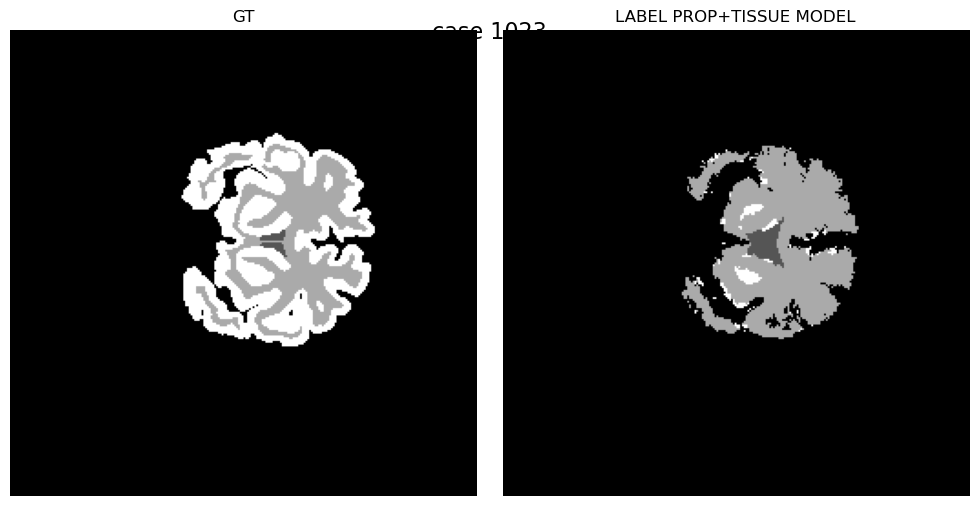

{1: 0.5327975271923346, 2: 0.7232894580379777, 3: 0.12170540086907727}
Dice for case 1023
case 1024, idx 6
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.8411622359591014)
{1: 0.6107546594188916, 2: 0.7068314657887073, 3: 0.1263610182128892}
Dice for case 1024
case 1025, idx 7
(0.0, 0.9859088774072334)
(0.0, 0.9762024956716513)
(0.0, 0.759676953737731)
{1: 0.8513843503377129, 2: 0.6852324838288336, 3: 0.12755460400858565}
Dice for case 1025
case 1038, idx 8
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9561211057481351)
{1: 0.6961252246096675, 2: 0.7233747423998217, 3: 0.12440015828121266}
Dice for case 1038
case 1039, idx 9
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.8452157617129128)
{1: 0.5888139792278433, 2: 0.7080004542944319, 3: 0.13059208638334588}
Dice for case 1039
case 1101, idx 10
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9102323838080959)


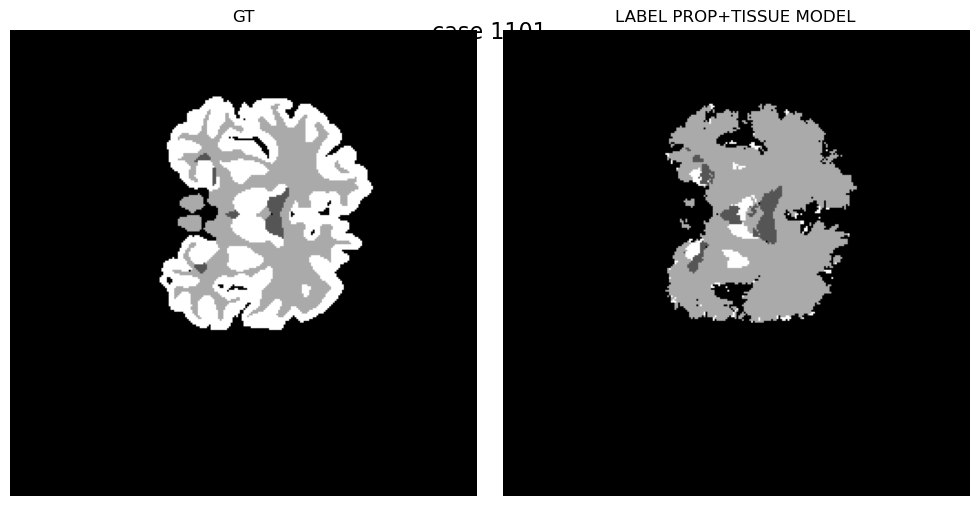

{1: 0.7703862661281695, 2: 0.7030960831600217, 3: 0.12285427416435497}
Dice for case 1101
case 1104, idx 11
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.8873435892058487)
{1: 0.7462491257933243, 2: 0.6823126003693982, 3: 0.1200880178896224}
Dice for case 1104
case 1107, idx 12
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9754056795131846)
{1: 0.7400776407265549, 2: 0.709302081086081, 3: 0.1140162175687411}
Dice for case 1107
case 1110, idx 13
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9384645825089039)
{1: 0.7255865090125394, 2: 0.714307407763729, 3: 0.12586667714910324}
Dice for case 1110
case 1113, idx 14
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.8452157617129128)
{1: 0.7530469198363177, 2: 0.7415866441962142, 3: 0.12254786059775385}
Dice for case 1113
case 1116, idx 15
(0.0, 0.9859088774072334)
(0.0, 0.9762024956716513)
(0.0, 0.7801991938718076)


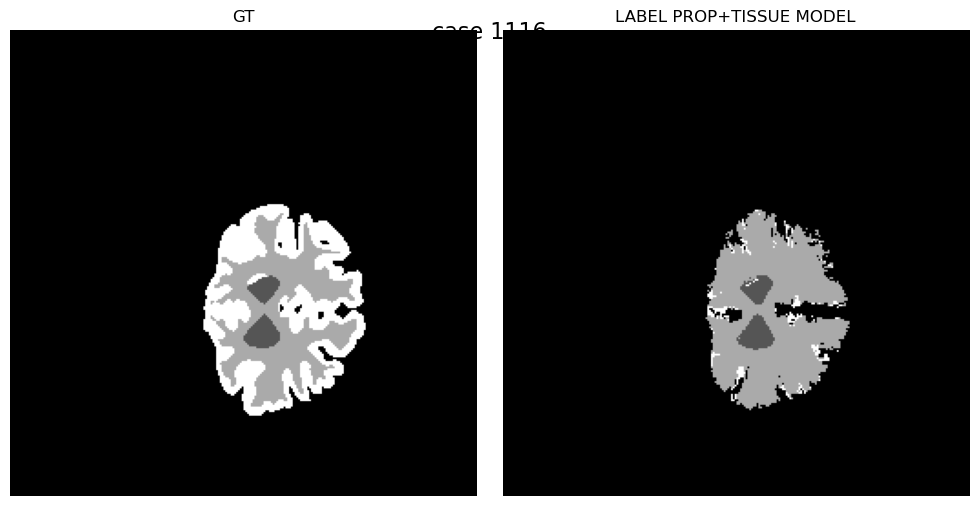

{1: 0.806696384367836, 2: 0.7145543184172808, 3: 0.14407621427026376}
Dice for case 1116
case 1119, idx 16
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9827021972884525)
{1: 0.8509503826338394, 2: 0.7007829783602825, 3: 0.12080987965401888}
Dice for case 1119
case 1122, idx 17
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9102323838080959)
{1: 0.8553413419448765, 2: 0.6589393513838628, 3: 0.1222119063189024}
Dice for case 1122
case 1125, idx 18
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.981562572021203)
{1: 0.8909899672138063, 2: 0.7005894378811354, 3: 0.12911948101163467}
Dice for case 1125
case 1128, idx 19
(0.0, 0.9186396036370742)
(0.0, 0.9762024956716513)
(0.0, 0.9951923076923077)
{1: 0.801703786077207, 2: 0.6752814874292951, 3: 0.12696028343224808}
Dice for case 1128


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.555866,0.589328,0.870792,0.652229,0.528695,0.532798,0.610755,0.851384,0.696125,0.588814,0.770386,0.746249,0.740078,0.725587,0.753047,0.806696,0.850950,0.855341,0.890990,0.801704
2,0.735448,0.727534,0.680803,0.727367,0.699353,0.723289,0.706831,0.685232,0.723375,0.708000,0.703096,0.682313,0.709302,0.714307,0.741587,0.714554,0.700783,0.658939,0.700589,0.675281
3,0.114826,0.137064,0.122851,0.122571,0.133155,0.121705,0.126361,0.127555,0.124400,0.130592,0.122854,0.120088,0.114016,0.125867,0.122548,0.144076,0.120810,0.122212,0.129119,0.126960


In [14]:
gts = []
masks = []
registered_labels = []
dice_scores = {}

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        results = results_for_case(case_id)

        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 5000, cv2.NORM_MINMAX)

        registered_labels.append(
            segment_using_intensity_and_position(
                image, results["probmap1"], results["probmap2"], results["probmap3"], bins, csf_hist, gm_hist, wm_hist, results["probmap0"]))
        
        if i % 5 == 0:
            compare([gts[i][:,160,:], registered_labels[i][:,160,:]],["GT", "LABEL PROP+TISSUE MODEL"], fig_title=f"case {case_id}")
        
        dice =  dice_score_per_label(gts[i].ravel(), registered_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        
        print(dice)
        print(f"Dice for case {case_id}")
    except Exception as e:
        print(e)


trained_df_label_propagation_tissue_model = pd.DataFrame(data=dice_scores)
trained_df_label_propagation_tissue_model

In [15]:
trained_df_label_propagation_tissue_model_dices = pd.DataFrame(trained_df_label_propagation_tissue_model.T.mean(), columns=["label_prop_tissue_mod_segment"])

trained_df_label_propagation_tissue_model_dices = trained_df_label_propagation_tissue_model_dices.apply(lambda row: np.round(row, 6))
trained_df_label_propagation_tissue_model_dices

,label_prop_tissue_mod_segment
1,0.720891
2,0.705899
3,0.125482


### Results

In [16]:
result_dices = pd.concat([trained_df_label_propagation_dices, trained_df_tissue_model_dices, trained_df_label_propagation_tissue_model_dices], axis=1)
result_dices

,label_prop_segment,tissue_mod_segment,label_prop_tissue_mod_segment
1,0.706988,0.000000,0.720891
2,0.761206,0.847823,0.705899
3,0.754242,0.869847,0.125482


Pretty solid results for only spacial information segmentation

## Template

In [17]:
gts = []
masks = []
registered_labels = []
dice_scores = {}

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        results = results_for_case(case_id, template_atlas=True)
        labels = results["labels"]

        # Fix-labels
        labels[labels==2] = -1
        labels[labels==3] = 2
        labels[labels==-1] = 3


        registered_labels.append(labels)
        dice =  dice_score_per_label(gts[i].ravel(), registered_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)


template_df_tissue_model= pd.DataFrame(data=dice_scores)
template_df_tissue_model

case 1003, idx 0
Dice for case 1003
{1: 0.5185300049007443, 2: 0.7063346990265663, 3: 0.6786292945567813}
case 1004, idx 1
Dice for case 1004
{1: 0.6986899564363035, 2: 0.6948009032909429, 3: 0.6954764436937416}
case 1005, idx 2
Dice for case 1005
{1: 0.7803446172822941, 2: 0.6767016888978457, 3: 0.6829725889807796}
case 1018, idx 3
Dice for case 1018
{1: 0.7268758294196482, 2: 0.6949747582756624, 3: 0.7073047275892369}
case 1019, idx 4
Dice for case 1019
{1: 0.5664666515310024, 2: 0.6887495566950013, 3: 0.6974326848527299}
case 1023, idx 5
Dice for case 1023
{1: 0.5329319564369481, 2: 0.6995447079065755, 3: 0.6961551287225177}
case 1024, idx 6
Dice for case 1024
{1: 0.6701555245558504, 2: 0.697294209747571, 3: 0.7107066176185406}
case 1025, idx 7
Dice for case 1025
{1: 0.7780365171153172, 2: 0.6803486736551635, 3: 0.6884885555149654}
case 1038, idx 8
Dice for case 1038
{1: 0.7510845352127703, 2: 0.6971349059464526, 3: 0.7074730174106239}
case 1039, idx 9
Dice for case 1039
{1: 0.61603

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.518530,0.698690,0.780345,0.726876,0.566467,0.532932,0.670156,0.778037,0.751085,0.616038,0.743980,0.758948,0.737071,0.737228,0.744466,0.745108,0.804388,0.788587,0.807687,0.739621
2,0.706335,0.694801,0.676702,0.694975,0.688750,0.699545,0.697294,0.680349,0.697135,0.682053,0.703336,0.711835,0.711438,0.725098,0.713189,0.681358,0.691703,0.710197,0.702799,0.717538
3,0.678629,0.695476,0.682973,0.707305,0.697433,0.696155,0.710707,0.688489,0.707473,0.684739,0.705736,0.723265,0.657050,0.699668,0.675212,0.693707,0.615522,0.675690,0.681275,0.688160


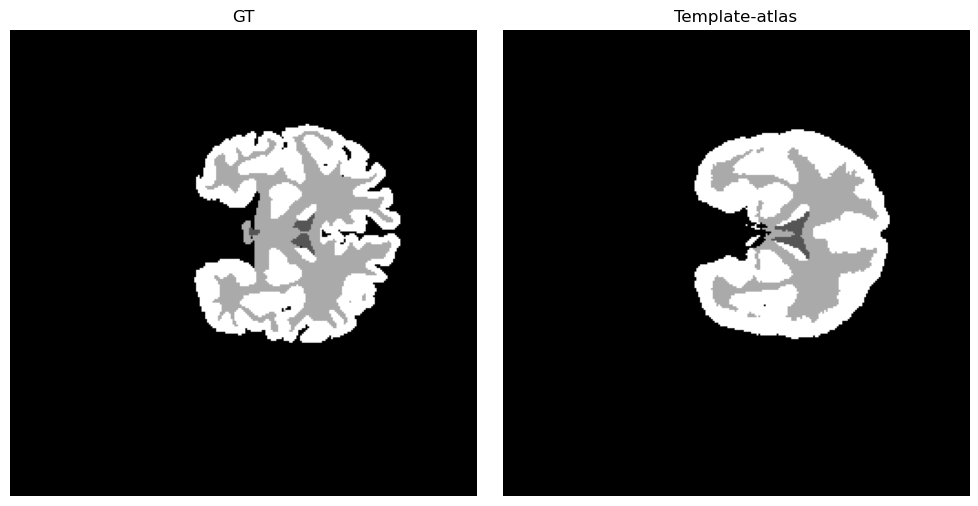

In [18]:
slice_i=160
compare([gts[0][:,slice_i,:], registered_labels[0][:,slice_i,:]], ["GT", "Template-atlas"])


### Results

In [19]:
template_df_label_prop_dices = template_df_tissue_model.T.mean()
template_df_label_prop_dices = pd.DataFrame(template_df_label_prop_dices, columns=["template_label_prop_segment"])
template_df_label_prop_dices

,template_label_prop_segment
1,0.712312
2,0.699321
3,0.688233


Something must have went wrong during the registration 

## Compare

In [20]:
results_df = pd.concat([trained_df_tissue_model_dices, trained_df_label_propagation_dices, template_df_label_prop_dices], axis=1)
results_df

,tissue_mod_segment,label_prop_segment,template_label_prop_segment
1,0.000000,0.706988,0.712312
2,0.847823,0.761206,0.699321
3,0.869847,0.754242,0.688233


# EM

## KMeans init

In [21]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

# Initialize using K-means with regularization
def initialize_parameters_kmeans(image_flat, num_classes):
    print("start_kmeans")
    # Use K-means to initialize
    kmeans = KMeans(n_clusters=num_classes, random_state=42).fit(image_flat)
    means = kmeans.cluster_centers_.flatten()

    print("means")
    print(means)

    # Compute initial variances and apply regularization
    variances = np.array([np.var(image_flat[kmeans.labels_ == i]) for i in range(num_classes)])
    variances = np.maximum(variances, 1e-6)  # Regularize variances (ensure they are not too small)

    mixing_coeffs = np.array([np.sum(kmeans.labels_ == i) for i in range(num_classes)]) / len(image_flat)

    return means, variances, mixing_coeffs


# E-step: Compute memberships with regularization
def expectation_step(image_flat, means, variances, mixing_coeffs, num_classes):
    memberships = np.zeros((image_flat.shape[0], num_classes))

    # Calculate membership for each class
    for c in range(num_classes):
        prob = multivariate_normal(mean=means[c], cov=variances[c], allow_singular=True).pdf(image_flat)
        memberships[:, c] = mixing_coeffs[c] * prob

    # Normalize
    memberships /= memberships.sum(axis=1, keepdims=True)
    return memberships

# M-step: Update parameters with regularization
def maximization_step(image_flat, memberships, num_classes):
    weights = memberships.sum(axis=0)
    means = np.dot(memberships.T, image_flat) / weights[:, np.newaxis]

    # Compute variances with regularization
    variances = np.array([np.dot(memberships[:, c] * (image_flat - means[c]).T, image_flat - means[c]) / weights[c]
                          for c in range(num_classes)])
    variances = np.maximum(variances, 1e-6)  # Regularize variances (ensure they are not too small)

    mixing_coeffs = weights / len(image_flat)

    return means.flatten(), variances.flatten(), mixing_coeffs

# GMM segmentation for 3D image data with regularization
def em_segmentation(image, binary_mask, num_classes=3, max_iters=100, tol=1e-5):
    # Flatten the 3D image
    image_flat = image[binary_mask == 1].reshape(-1, 1)

    # Initialize using K-means
    means, variances, mixing_coeffs = initialize_parameters_kmeans(image_flat, num_classes)

    for iteration in range(max_iters):
        if iteration % 25 == 0:
            print(f"Iteration: {iteration}/{max_iters}")
        memberships = expectation_step(image_flat, means, variances, mixing_coeffs, num_classes)
        new_means, new_variances, new_mixing_coeffs = maximization_step(image_flat, memberships, num_classes)

        # Check convergence
        if np.allclose(means, new_means, atol=tol) and np.allclose(variances, new_variances, atol=tol):
            print(f"Converged at iteration {iteration}")
            break

        means, variances, mixing_coeffs = new_means, new_variances, new_mixing_coeffs

    # Final segmentation: Assign each voxel to the class with the highest membership
    segmentation = np.argmax(memberships, axis=1)

    # Reshape segmentation back to 3D
    segmentation_3d = np.zeros_like(image)
    segmentation_3d[binary_mask == 1] = segmentation + 1  # Shift labels for visualization

    return segmentation_3d, (means, variances, mixing_coeffs)

In [22]:
case_id = 1003

image = image_for_case(case_id)
image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)

mask = mask_for_case(case_id)
labels = labels_for_case(case_id)
atlas = results_for_case(case_id)
pred_labels = atlas["labels"]
atlas = atlas["probmaps"]

res = em_segmentation(image, mask, 3, 500, 1e-3)

start_kmeans
means
[0.24300627 0.3283475  0.17600668]
Iteration: 0/500
Converged at iteration 2


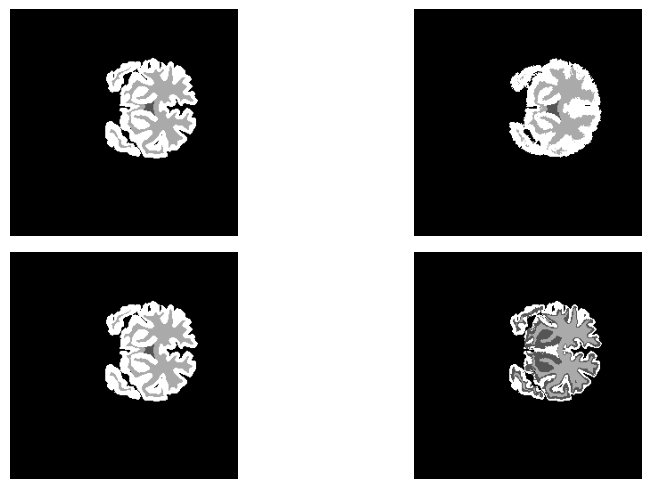

In [23]:
slice_i = 170
compare([labels[:,slice_i,:],pred_labels[:,slice_i,:,],
         labels[:,slice_i,:], res[0][:,slice_i,:,]],rows=2, )

In [24]:
gts = []
masks = []
segmented_labels = []
segmented_models = []

dice_scores = {}
#segmentation_method(atlas_path)

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)

        results = em_segmentation(image, masks[i], 3, 500, 1e-4)

        segmented_labels.append(results[0])
        segmented_models.append(results[1])

        dice =  dice_score_per_label(gts[i].ravel(), segmented_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)
kmeans_init_df = pd.DataFrame(data=dice_scores)

case 1003, idx 0
start_kmeans
means
[0.24300627 0.3283475  0.17600668]
Iteration: 0/500
Iteration: 25/500
Iteration: 50/500
Iteration: 75/500
Iteration: 100/500
Iteration: 125/500
Iteration: 150/500
Iteration: 175/500
Converged at iteration 184
Dice for case 1003
{1: 0.00017617796084001009, 2: 0.7649852161530768, 3: 0.9059168940630312}
case 1004, idx 1
start_kmeans
means
[0.22494131 0.30744595 0.16429769]
Iteration: 0/500
Iteration: 25/500
Iteration: 50/500
Iteration: 75/500
Iteration: 100/500
Iteration: 125/500
Iteration: 150/500
Converged at iteration 171
Dice for case 1004
{1: 1.4614524608437142e-05, 2: 0.748934304386314, 3: 0.9372473605994484}
case 1005, idx 2
start_kmeans
means
[0.2260427  0.14274275 0.33296405]
Iteration: 0/500
Iteration: 25/500
Iteration: 50/500
Iteration: 75/500
Iteration: 100/500
Converged at iteration 111
Dice for case 1005
{1: 0.04938768271619981, 2: 8.414001277237187e-05, 3: 0.018754645600295418}
case 1018, idx 3
start_kmeans
means
[0.1836117  0.25163974 0.

### Result

In [25]:
kmeans_init_df_scores = pd.DataFrame(kmeans_init_df.T.mean(), columns=["kmeans_init__em_segment"])
kmeans_init_df_scores

,kmeans_init__em_segment
1,0.059701
2,0.386391
3,0.456520


## Label propagation initialization

In [26]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

def initialize_parameters_label_prop(image, binary_mask, atlas, num_classes):
    print("Start label propagation initialization")
    
    # Flatten the image and atlas based on the binary mask
    image_flat = image[binary_mask == 1].reshape(-1)
    labels = np.argmax(atlas, axis=3)
    labels_flat = labels[binary_mask == 1]
    
    means = []
    variances = []
    mixing_coeffs = []
    
    # Loop through each unique label in the atlas (excluding background if label 0 is background)
    for label in range(1, num_classes + 1):  # assuming labels start from 1 for tissues
        class_pixels = image_flat[labels_flat == label]  # Pixels in this class
        
        if class_pixels.size == 0:
            # If there are no pixels for this class in the image, assign default values
            means.append(0)
            variances.append(1)
            mixing_coeffs.append(0)
            continue
        
        # Calculate mean and variance for this class
        mean = np.mean(class_pixels)
        variance = np.var(class_pixels)
        
        # Mixing coefficient as the proportion of pixels in this class
        mixing_coeff = class_pixels.size / image_flat.size

        means.append(mean)
        variances.append(variance)
        mixing_coeffs.append(mixing_coeff)
    
    print("Means:", means)
    print("Variances:", variances)
    print("Mixing Coefficients:", mixing_coeffs)
    
    return np.array(means), np.array(variances), np.array(mixing_coeffs)

# GMM segmentation for 3D image data with regularization
def em_segmentation2(image, binary_mask, atlas, num_classes=3, max_iters=100, tol=1e-4):
    # Flatten the 3D image
    image_flat = image[binary_mask == 1].reshape(-1, 1)

    # Initialize using label propagation
    means, variances, mixing_coeffs = initialize_parameters_label_prop(image, binary_mask, atlas, num_classes)

    for iteration in range(max_iters):
        if iteration % 50 == 0:
            print(f"Iteration: {iteration}/{max_iters}")
        memberships = expectation_step(image_flat, means, variances, mixing_coeffs, num_classes)
        new_means, new_variances, new_mixing_coeffs = maximization_step(image_flat, memberships, num_classes)

        # Check convergence
        if np.allclose(means, new_means, atol=tol) and np.allclose(variances, new_variances, atol=tol):
            print(f"Converged at iteration {iteration}")
            break

        means, variances, mixing_coeffs = new_means, new_variances, new_mixing_coeffs
        if iteration == max_iters-1:
            print(f"Reached maximum iterations {max_iters}")

    # Final segmentation: Assign each voxel to the class with the highest membership
    segmentation = np.argmax(memberships, axis=1)

    # Reshape segmentation back to 3D
    segmentation_3d = np.zeros_like(image)
    segmentation_3d[binary_mask == 1] = segmentation + 1  # Shift labels for visualization

    return segmentation_3d, (means, variances, mixing_coeffs)

In [27]:
case_id = 1003

image = image_for_case(case_id)
image = cv2.normalize(image,None,0,1, cv2.NORM_MINMAX,)

mask = mask_for_case(case_id)
labels = labels_for_case(case_id)
atlas = results_for_case(case_id)
pred_labels = atlas["labels"]
atlas = atlas["probmaps"]

res_atlas2 = em_segmentation2(image, mask, atlas, 3, 500, 1e-4)

Start label propagation initialization
Means: [0.18797640900680052, 0.30705801257106125, 0.22942357623817713]
Variances: [0.00582466463883632, 0.0026652550127544963, 0.002731084170716795]
Mixing Coefficients: [0.009635158112459727, 0.36469244362267955, 0.5316642249544316]
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Converged at iteration 132


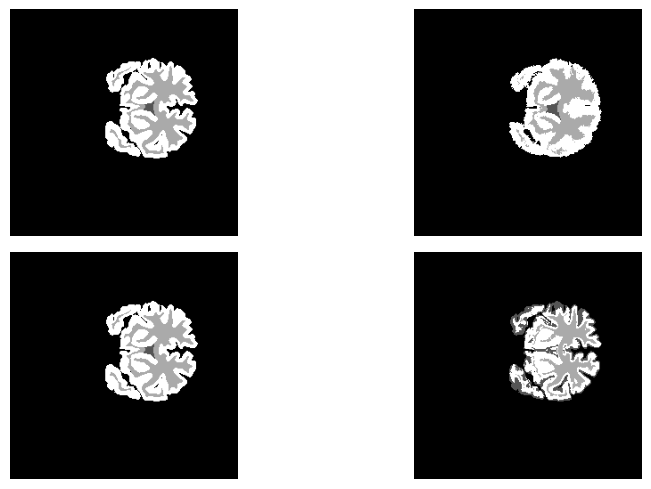

In [28]:
slice_i = 170
compare([labels[:,slice_i,:],pred_labels[:,slice_i,:,],
         labels[:,slice_i,:], res_atlas2[0][:,slice_i,:,]],rows=2, )

In [29]:
gts = []
masks = []
images = []
segmented_labels = []
segmented_models = []

dice_scores = {}
#segmentation_method(atlas_path)

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
        results = em_segmentation2(image, masks[i], results_for_case(case_id)["probmaps"], 3, 500, 1e-4)

        segmented_labels.append(results[0])
        segmented_models.append(results[1])

        dice =  dice_score_per_label(gts[i].ravel(), segmented_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)

label_prop_init_df  = pd.DataFrame(data=dice_scores)

case 1003, idx 0
Start label propagation initialization
Means: [0.18797640900680052, 0.30705801257106125, 0.22942357623817713]
Variances: [0.00582466463883632, 0.0026652550127544963, 0.002731084170716795]
Mixing Coefficients: [0.009635158112459727, 0.36469244362267955, 0.5316642249544316]
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Converged at iteration 132
Dice for case 1003
{1: 0.03143809732921121, 2: 0.8275450588651718, 3: 0.6779118456319825}
case 1004, idx 1
Start label propagation initialization
Means: [0.13156098026791682, 0.27981269928116914, 0.2100074587303734]
Variances: [0.004811192429554108, 0.0028109179844061395, 0.002464487027965281]
Mixing Coefficients: [0.011449310546065369, 0.38985406203361017, 0.5515333934279565]
Iteration: 0/500
Iteration: 50/500
Converged at iteration 81
Dice for case 1004
{1: 0.4126779428536888, 2: 0.896595513598019, 3: 0.9339082715194114}
case 1005, idx 2
Start label propagation initialization
Means: [0.08447205428903438, 0.2973000795588

### Result

In [30]:
label_prop_init_df_scores = pd.DataFrame(label_prop_init_df.T.mean(), columns=["label_prop_init__em_segment"])
label_prop_init_df_scores

,label_prop_init__em_segment
1,0.325977
2,0.848603
3,0.879580


## Tissue model initialization

[   0.     76.22  152.44  228.66  304.88  381.1   457.32  533.54  609.76
  685.98  762.2   838.42  914.64  990.86 1067.08 1143.3  1219.52 1295.74
 1371.96 1448.18 1524.4  1600.62 1676.84 1753.06 1829.28 1905.5  1981.72
 2057.94 2134.16 2210.38 2286.6  2362.82 2439.04 2515.26 2591.48 2667.7
 2743.92 2820.14 2896.36 2972.58 3048.8  3125.02 3201.24 3277.46 3353.68
 3429.9  3506.12 3582.34 3658.56 3734.78]


(array([25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667,
        25.40666667, 25.40666667, 25.40666667, 25.40666667, 25.40666667]),
 array([1290.99742222, 1237.19163371,  977.57668102,  904.33058   ,
         806.67844141,  729.75859266,  861.77936103,  970.96888909,
         998.41796661,  976.73951548,  933.84638821,  861.38691161,
         750.32084885,  640.54711277,  513.78215819,  373.833524

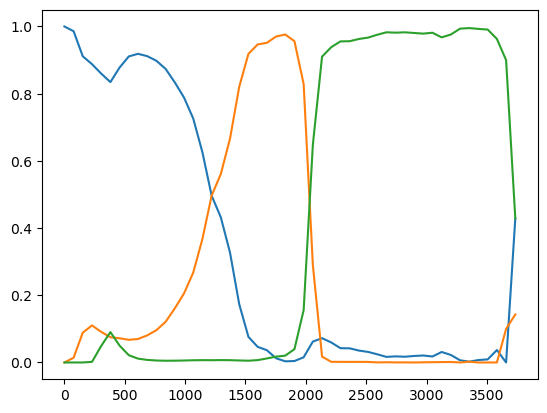

[(array([50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64), array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
       1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
       2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
       3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
       4500., 4600., 4700., 4800., 4900., 5000.])), (array([50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64), array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300.,

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

In [54]:
case_id = 1003

histograms = load_histograms(r"C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab3\tissue-model\tissue_histograms.pkl")
bins = histograms[3]
csf_hist = histograms[0]
gm_hist = histograms[1]
wm_hist = histograms[2]



plt.plot(bins, csf_hist)
plt.plot(bins, gm_hist)
plt.plot(bins, wm_hist)
plt.show()


image = image_for_case(case_id)
image = cv2.normalize(image,None,0,5000, cv2.NORM_MINMAX,)

mask = mask_for_case(case_id)
labels = labels_for_case(case_id)
atlas = results_for_case(case_id)

# res_atlas3 = em_segmentation3(image, mask, (csf_hist, gm_hist, wm_hist), bins, 3, 500, 1e-4)

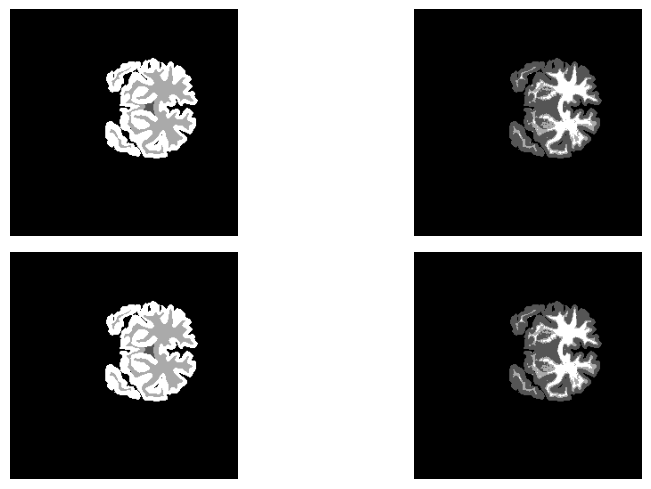

In [33]:
slice_i = 170
compare([labels[:,slice_i,:], res_atlas3[0][:,slice_i,:,],
         labels[:,slice_i,:], res_atlas3[0][:,slice_i,:,]],rows=2, )

In [35]:
gts = []
masks = []
images = []
segmented_labels = []
segmented_models = []

dice_scores = {}
#segmentation_method(atlas_path)

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
        results = em_segmentation3(image, masks[i], results_for_case(case_id)["probmaps"], 3, 500, 1e-4)

        segmented_labels.append(results[0])
        segmented_models.append(results[1])

        dice =  dice_score_per_label(gts[i].ravel(), segmented_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)

tissue_model_init_df  = pd.DataFrame(data=dice_scores)

case 1003, idx 0
Start GMM initialization from histograms
'int' object is not subscriptable
case 1004, idx 1
Start GMM initialization from histograms
'int' object is not subscriptable
case 1005, idx 2


KeyboardInterrupt: 

### Results

In [128]:
tissue_model_init_df_dices = pd.DataFrame(tissue_model_init_df.T.mean(), columns=["tissue_model_init__em_segment"])
tissue_model_init_df_dices

,tissue_model_init__em_segment
1,0.325977
2,0.848603
3,0.879580


## A posteriori label propagation

In [60]:
flatten = lambda image, binary_mask: image[binary_mask == 1].reshape(-1, 1)

# GMM segmentation for 3D image data with regularization
def em_segmentation4(image, binary_mask, atlas, num_classes=3, max_iters=100, tol=1e-3):
    print(image.shape)
    # Flatten the 3D image
    image_flat = image[binary_mask == 1].reshape(-1, 1)

    # Initialize using label propagation
    means, variances, mixing_coeffs = initialize_parameters_label_prop(image, binary_mask, atlas, num_classes)

    for iteration in range(max_iters):
        if iteration % 50 == 0:
            print(f"Iteration: {iteration}/{max_iters}")
        memberships = expectation_step(image_flat, means, variances, mixing_coeffs, num_classes)
        new_means, new_variances, new_mixing_coeffs = maximization_step(image_flat, memberships, num_classes)

        # Check convergence
        if np.allclose(means, new_means, atol=tol) and np.allclose(variances, new_variances, atol=tol):
            print(f"Converged at iteration {iteration}")
            break

        means, variances, mixing_coeffs = new_means, new_variances, new_mixing_coeffs
        if iteration == max_iters-1:
            print(f"Reached maximum iterations {max_iters}")

    
    atlases = np.array((
        flatten(atlas[:,:,:,1],binary_mask).flatten(),
        flatten(atlas[:,:,:,2],binary_mask).flatten(),
        flatten(atlas[:,:,:,3],binary_mask).flatten()
    )).T
    
    posteriori_atlas_weights = memberships * atlases

    # Final segmentation: Assign each voxel to the class with the highest membership
    segmentation = np.argmax(posteriori_atlas_weights, axis=1)

    # Reshape segmentation back to 3D
    segmentation_3d = np.zeros_like(image)
    segmentation_3d[binary_mask == 1] = segmentation + 1  # Shift labels for visualization

    return segmentation_3d, (means, variances, mixing_coeffs)

(256, 316, 256)
Start label propagation initialization
Means: [0.18797640900680052, 0.30705801257106125, 0.22942357623817713]
Variances: [0.00582466463883632, 0.0026652550127544963, 0.002731084170716795]
Mixing Coefficients: [0.009635158112459727, 0.36469244362267955, 0.5316642249544316]
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Converged at iteration 132


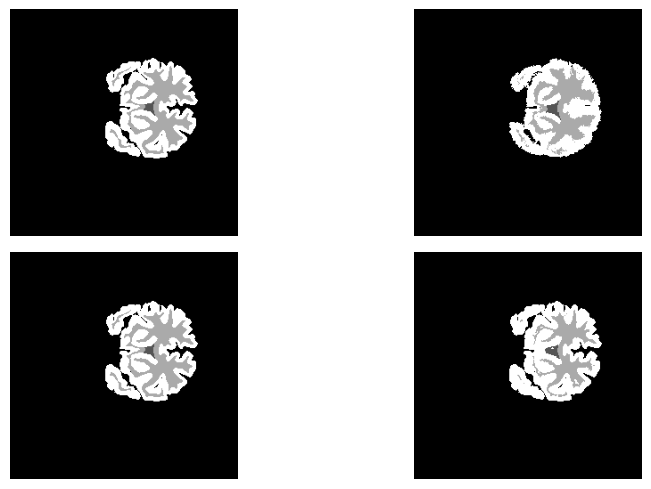

In [61]:
case_id = 1003

image = image_for_case(case_id)
image = cv2.normalize(image,None,0,1, cv2.NORM_MINMAX,)

mask = mask_for_case(case_id)
labels = labels_for_case(case_id)
atlas = results_for_case(case_id)
pred_labels = atlas["labels"]
atlas = atlas["probmaps"]

res_atlas3 = em_segmentation4(image, mask, atlas, 3, 500, 1e-4)
slice_i = 170
compare([labels[:, slice_i, :], pred_labels[:, slice_i, :, ],
         labels[:, slice_i, :], res_atlas3[0][:, slice_i, :, ]], rows=2)

In [ ]:
gts = []
masks = []
images = []
segmented_labels = []
segmented_models = []

dice_scores = {}
#segmentation_method(atlas_path)

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
        results = em_segmentation4(image, masks[i], results_for_case(case_id)["probmaps"], 3, 500, 1e-4)

        segmented_labels.append(results[0])
        segmented_models.append(results[1])

        dice =  dice_score_per_label(gts[i].ravel(), segmented_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)

label_prop_init_posteriori_df = pd.DataFrame(data=dice_scores)

case 1003, idx 0
(256, 316, 256)
Start label propagation initialization
Means: [0.18797640900680052, 0.30705801257106125, 0.22942357623817713]
Variances: [0.00582466463883632, 0.0026652550127544963, 0.002731084170716795]
Mixing Coefficients: [0.009635158112459727, 0.36469244362267955, 0.5316642249544316]
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Converged at iteration 132
Dice for case 1003
{1: 0.5088098919770531, 2: 0.8529051516856051, 3: 0.9209205150827642}
case 1004, idx 1
(256, 310, 256)
Start label propagation initialization
Means: [0.13156098026791682, 0.27981269928116914, 0.2100074587303734]
Variances: [0.004811192429554108, 0.0028109179844061395, 0.002464487027965281]
Mixing Coefficients: [0.011449310546065369, 0.38985406203361017, 0.5515333934279565]
Iteration: 0/500
Iteration: 50/500
Converged at iteration 81
Dice for case 1004
{1: 0.6550694639325387, 2: 0.9205014519603913, 3: 0.9502831105196832}
case 1005, idx 2
(256, 284, 256)
Start label propagation initializat

### Result

In [114]:
label_prop_init_posteriori_df_scores = pd.DataFrame(label_prop_init_posteriori_df.T.mean(), columns=["label_prop_init_aposteriori__em_segment"])
label_prop_init_posteriori_df_scores

,label_prop_init_aposteriori__em_segment
1,0.679856
2,0.879878
3,0.933093


## EM integral label propagation


In [115]:
flatten = lambda image, binary_mask: image[binary_mask == 1].reshape(-1, 1)

# E-step: Compute memberships with regularization with spatial probabilites
def expectation_step_mod(image_flat, means, variances, mixing_coeffs, num_classes, atlases):
    memberships = np.zeros((image_flat.shape[0], num_classes))

    # Calculate membership for each class
    for c in range(num_classes):
        prob = multivariate_normal(mean=means[c], cov=variances[c], allow_singular=True).pdf(image_flat)
        memberships[:, c] = mixing_coeffs[c] * prob

    # Normalize
    memberships /= memberships.sum(axis=1, keepdims=True)
    
    memberships = memberships * atlases
    return memberships

# GMM segmentation for 3D image data with regularization
def em_segmentation5(image, binary_mask, atlas, num_classes=3, max_iters=100, tol=1e-3):
    # Flatten the 3D image
    image_flat = image[binary_mask == 1].reshape(-1, 1)
    atlases = np.array((
        flatten(atlas[:,:,:,1],binary_mask).flatten(),
        flatten(atlas[:,:,:,2],binary_mask).flatten(),
        flatten(atlas[:,:,:,3],binary_mask).flatten()
    )).T

    # Initialize using label propagation
    means, variances, mixing_coeffs = initialize_parameters_label_prop(image, binary_mask, atlas, num_classes)

    for iteration in range(max_iters):
        if iteration % 50 == 0:
            print(f"Iteration: {iteration}/{max_iters}")
        memberships = expectation_step_mod(image_flat, means, variances, mixing_coeffs, num_classes, atlases)
                
        new_means, new_variances, new_mixing_coeffs = maximization_step(image_flat, memberships, num_classes)

        # Check convergence
        if np.allclose(means, new_means, atol=tol) and np.allclose(variances, new_variances, atol=tol):
            print(f"Converged at iteration {iteration}")
            break

        means, variances, mixing_coeffs = new_means, new_variances, new_mixing_coeffs
        if iteration == max_iters-1:
            print(f"Reached maximum iterations {max_iters}")

    # Final segmentation: Assign each voxel to the class with the highest membership
    segmentation = np.argmax(memberships, axis=1)

    # Reshape segmentation back to 3D
    segmentation_3d = np.zeros_like(image)
    segmentation_3d[binary_mask == 1] = segmentation + 1  # Shift labels for visualization

    return segmentation_3d, (means, variances, mixing_coeffs)

Start label propagation initialization
Means: [0.18797640900680052, 0.30705801257106125, 0.22942357623817713]
Variances: [0.00582466463883632, 0.0026652550127544963, 0.002731084170716795]
Mixing Coefficients: [0.009635158112459727, 0.36469244362267955, 0.5316642249544316]
Iteration: 0/500
Converged at iteration 5


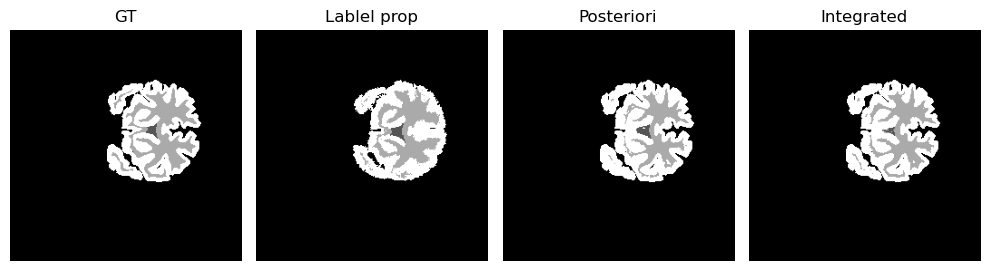

In [116]:
case_id = 1003

image = image_for_case(case_id)
image = cv2.normalize(image,None,0,1, cv2.NORM_MINMAX,)

mask = mask_for_case(case_id)
labels = labels_for_case(case_id)
atlas = results_for_case(case_id)
pred_labels = atlas["labels"]
atlas = atlas["probmaps"]

res_atlas4 = em_segmentation5(image, mask, atlas, 3, 500, 1e-3)
slice_i = 170
compare([labels[:, slice_i, :], pred_labels[:, slice_i, :],
         res_atlas3[0][:, slice_i, :], res_atlas4[0][:, slice_i, :]],
        ["GT", "Lablel prop", "Posteriori", "Integrated"],
)

In [117]:
gts = []
masks = []
images = []
segmented_labels = []
segmented_models = []

dice_scores = {}
#segmentation_method(atlas_path)

for i, case_id in enumerate(CASES):
    try:
        print(f"case {case_id}, idx {i}")
        gts.append(labels_for_case(case_id))
        masks.append(mask_for_case(case_id))
        image = image_for_case(case_id)
        image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
        results = em_segmentation5(image, masks[i], results_for_case(case_id)["probmaps"], 3, 500, 1e-3)

        segmented_labels.append(results[0])
        segmented_models.append(results[1])

        dice =  dice_score_per_label(gts[i].ravel(), segmented_labels[i].ravel(), np.array([1, 2, 3]).astype(int))
        dice_scores[i] = dice
        print(f"Dice for case {case_id}")
        print(dice)
    except Exception as e:
        print(e)

label_prop_init_internal_df = pd.DataFrame(data=dice_scores)

case 1003, idx 0
Start label propagation initialization
Means: [0.18797640900680052, 0.30705801257106125, 0.22942357623817713]
Variances: [0.00582466463883632, 0.0026652550127544963, 0.002731084170716795]
Mixing Coefficients: [0.009635158112459727, 0.36469244362267955, 0.5316642249544316]
Iteration: 0/500
Converged at iteration 5
Dice for case 1003
{1: 0.33666206345656957, 2: 0.9163343801058648, 3: 0.9477150029772471}
case 1004, idx 1
Start label propagation initialization
Means: [0.13156098026791682, 0.27981269928116914, 0.2100074587303734]
Variances: [0.004811192429554108, 0.0028109179844061395, 0.002464487027965281]
Mixing Coefficients: [0.011449310546065369, 0.38985406203361017, 0.5515333934279565]
Iteration: 0/500
Converged at iteration 3
Dice for case 1004
{1: 0.7050819112451702, 2: 0.9439934972514499, 3: 0.9621318545491612}
case 1005, idx 2
Start label propagation initialization
Means: [0.08447205428903438, 0.2973000795588993, 0.22564042101173232]
Variances: [0.00479717465000602

### Result

In [118]:
label_prop_init_internal_df_scores = pd.DataFrame(label_prop_init_internal_df.T.mean(), columns=["label_prop_init_integrated__em_segment"])
label_prop_init_internal_df_scores

,label_prop_init_integrated__em_segment
1,0.634993
2,0.920479
3,0.949727


# Eval

In [119]:
results = (
    template_df_label_prop_dices,
    trained_df_label_propagation_dices,
    trained_df_tissue_model_dices,
    trained_df_label_propagation_tissue_model_dices,
    kmeans_init_df_scores,
    label_prop_init_df_scores,
    tissue_model_init_df_dices,
    label_prop_init_posteriori_df_scores,
    label_prop_init_internal_df_scores,
)

results_df = pd.concat(results, ignore_index=False, axis=1)
results_df

,template_label_prop_segment,label_prop_segment,tissue_mod_segment,label_prop_tissue_mod_segment,kmeans_init__em_segment,label_prop_init__em_segment,tissue_model_init__em_segment,label_prop_init_aposteriori__em_segment,label_prop_init_integrated__em_segment
1,0.712312,0.706988,0.000000,0.720891,0.042193,0.325977,0.325977,0.679856,0.634993
2,0.699321,0.761206,0.847823,0.705899,0.381747,0.848603,0.848603,0.879878,0.920479
3,0.688233,0.754242,0.869847,0.125482,0.489858,0.879580,0.879580,0.933093,0.949727
